In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
#https://stackoverflow.com/q/40845304/10704205
#Ignore RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility

import pandas as pd #数据分析
import numpy as np #科学计算
from pandas import Series,DataFrame

data_train = pd.read_csv('titanic/train.csv',engine = 'python',encoding='UTF-8')
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


F:\code\PythonProjects\learn\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22836 (\N{CJK UNIFIED IDEOGRAPH-5934}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
F:\code\PythonProjects\learn\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
F:\code\PythonProjects\learn\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33329 (\N{CJK UNIFIED IDEOGRAPH-8231}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


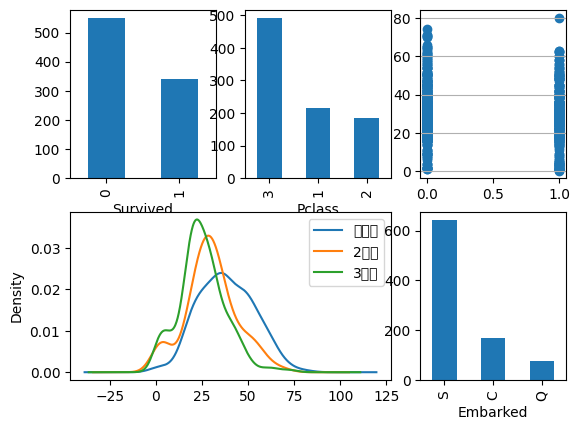

In [22]:
%matplotlib inline 
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

plt.subplot2grid((2,3),(0,0))             # 在一张大图里分列几个小图
data_train.Survived.value_counts().plot(kind='bar')# 柱状图 
# plt.title("获救情况 (1为获救)") # 标题
# plt.ylabel(u"人数")  

plt.subplot2grid((2,3),(0,1))
data_train.Pclass.value_counts().plot(kind="bar")
# plt.ylabel(u"人数")
# plt.title(u"乘客等级分布")
# 
plt.subplot2grid((2,3),(0,2))
plt.scatter(data_train.Survived, data_train.Age)
# plt.ylabel(u"年龄")                         # 设定纵坐标名称
plt.grid(which='major', axis='y') 
# plt.title(u"按年龄看获救分布 (1为获救)")
# 
# 
plt.subplot2grid((2,3),(1,0), colspan=2)
data_train.Age[data_train.Pclass == 1].plot(kind='kde')   
data_train.Age[data_train.Pclass == 2].plot(kind='kde')
data_train.Age[data_train.Pclass == 3].plot(kind='kde')
# plt.xlabel(u"年龄")# plots an axis lable
# plt.ylabel(u"密度") 
# plt.title(u"各等级的乘客年龄分布")
# plt.legend((u'头等舱', u'2等舱',u'3等舱'),loc='best') # sets our legend for our graph.
# 
# 
plt.subplot2grid((2,3),(1,2))
data_train.Embarked.value_counts().plot(kind='bar')
# plt.title(u"各登船口岸上船人数")
# plt.ylabel(u"人数")  
plt.show()